Objective: 
I want you to use data from sam.gov. The System for Award Management (SAM.gov) is an official website of the U.S. Government. This website provides contract data reports provide detailed information on awarded contracts using data directly from the Federal Data Procurement System (FPDS). The report data can be aggregated by various attributes and can be downloaded for detailed analysis.

This is publicly available data from the following location:

https://sam.gov/data-services/Contract%20Opportunities/Archived%20Data?privacy=Public

No preprocessing of data should be done outside of your Jupyter notebook. All processing/transformation and analysis should be done in the Notebook. You will be able to use of google colabortory (https://colab.research.google.com/)



# Data/ CSV should be loaded within the same folder

This project uses Jupyter Dash for the interactive dashboard portion. To use this I installed using pip - 'jupyter-dash' and 'ipywidgets' in my local environment

Dash references:
- https://dash.plotly.com/workspaces/using-dash-in-jupyter-and-workspaces
- https://www.youtube.com/watch?v=hSPmj7mK6ng&list=PLh3I780jNsiTXlWYiNWjq2rBgg3UsL1Ub&index=13
- https://www.youtube.com/watch?v=hSPmj7mK6ng
- https://dash.plotly.com/dash-core-components/graph
- https://towardsdatascience.com/dash101-part-1-introduction-to-dash-layout-810ec449ad43

**Installed libraries:**
- pip : 23.1.1
- Python: 3.11.0
- Matplotlib: 3.6.2
- Jupyter_dash: 0.4.2
- Dash: 2.9.3
- Scipy: 1.9.3

File size at final run: 735,239 bytes (737 KB on disk)

In [1]:
import pandas as pd
import plotly.express as px
from jupyter_dash import JupyterDash
import dash
from dash import Dash, html, dcc, Input, Output
import time


import requests
from io import StringIO

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# pd.options.display.float_format = "{:,.5f}".format

- Columns used for hypothesis are shown as below in read_csv function. There are 11 columns out of 47 possible columns.
- Columns were chosen based on personal discretion on what columns are necessary for visualization and hypothesis purposes like award amount, whether an opportunity was archived, department, state, etc.
- Initially, shown in the commented out section, I had used a for loop to concat and read all the csvs. But there is the problem that all the posted date columns do not have an actual date, 2020 and beyond have only included the hours, min, and seconds for most entries, while archive date is an actual date value.

In [2]:
files = ['FY2020_archived_opportunities.csv','FY2021_archived_opportunities.csv','FY2022_archived_opportunities.csv','FY2023_archived_opportunities.csv']
start_time = time.time() # Stamp time to get duration of file reading

# First attempt Read CSV files from List
# contracts = pd.concat(pd.read_csv(files[i], encoding='iso-8859-1',low_memory = False, usecols=['NoticeId', 'Title','Department/Ind.Agency',
#                                                                                         'FPDS Code','Office','PostedDate','Type','ArchiveDate','Active',
#                                                                                         'Award$','Awardee','State','Description']) 
#                for i in range(len(files)))

# below takes about the same amount of time, but keeps all the df separate so default year col can be added
# file is not UTF-8 encoded so using encoding below, which messes up Posted Date columns values
contract2020 = pd.read_csv(files[0], encoding='iso-8859-1',low_memory = False, 
                           usecols=['NoticeId', 'Title','Department/Ind.Agency','Sub-Tier',
                                    'Office','PostedDate','ArchiveDate',
                                    'Award$','Awardee','State'])

contract2021 = pd.read_csv(files[1], encoding='iso-8859-1',low_memory = False, 
                           usecols=['NoticeId', 'Title','Department/Ind.Agency','Sub-Tier',
                                    'Office','PostedDate','ArchiveDate',
                                    'Award$','Awardee','State'])

contract2022 = pd.read_csv(files[2], encoding='iso-8859-1',low_memory = False, 
                           usecols=['NoticeId', 'Title','Department/Ind.Agency','Sub-Tier',
                                    'Office','PostedDate','ArchiveDate',
                                    'Award$','Awardee','State'])

contract2023 = pd.read_csv(files[3], encoding='iso-8859-1',low_memory = False, 
                           usecols=['NoticeId', 'Title','Department/Ind.Agency','Sub-Tier',
                                    'Office','PostedDate','ArchiveDate',
                                    'Award$','Awardee','State'])
# adding default year col, 
contract2020['year'] = '2020'
contract2021['year'] = '2021'
contract2022['year'] = '2022'
contract2023['year'] = '2023'

contracts = pd.concat([contract2020,contract2021,contract2022,contract2023])

print("Duration of file reading: ", time.time() - start_time, " seconds")
print(contracts.shape)
# df.head(20)

Duration of file reading:  11.791343927383423  seconds
(1223631, 11)


In [3]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1223631 entries, 0 to 155513
Data columns (total 11 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   NoticeId               1223631 non-null  object
 1   Title                  1223628 non-null  object
 2   Department/Ind.Agency  1209242 non-null  object
 3   Sub-Tier               1207959 non-null  object
 4   Office                 1209194 non-null  object
 5   PostedDate             1223631 non-null  object
 6   ArchiveDate            1161863 non-null  object
 7   Award$                 233254 non-null   object
 8   Awardee                443430 non-null   object
 9   State                  1198200 non-null  object
 10  year                   1223631 non-null  object
dtypes: object(11)
memory usage: 112.0+ MB


In [4]:
# HHS department only had to deal with replacing ',' or '$' values in order to cast as float values for summation
# Did not bother to clean other rows of entire df since they will not be used in this scope
contracts['Award$'] = contracts['Award$'].str.replace(',', '',regex=True).str.replace('$', '',regex=True)

# HHS stands for Health and Human Services
HHS = contracts[contracts['Department/Ind.Agency']=='HEALTH AND HUMAN SERVICES, DEPARTMENT OF'].copy()


In [5]:
# create a new column for 'Award$' but as a float data type
HHS['float_money'] = HHS['Award$'].astype(float)
# subset of HHS department money awarded , sum()
print("Total Money Awarded to Health and Human Services departments across the U.S is: ", HHS['float_money'].sum())
HHS.info()


Total Money Awarded to Health and Human Services departments across the U.S is:  177042637409.92004
<class 'pandas.core.frame.DataFrame'>
Int64Index: 29443 entries, 57 to 155302
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   NoticeId               29443 non-null  object 
 1   Title                  29443 non-null  object 
 2   Department/Ind.Agency  29443 non-null  object 
 3   Sub-Tier               29389 non-null  object 
 4   Office                 29443 non-null  object 
 5   PostedDate             29443 non-null  object 
 6   ArchiveDate            24650 non-null  object 
 7   Award$                 2158 non-null   object 
 8   Awardee                2306 non-null   object 
 9   State                  29297 non-null  object 
 10  year                   29443 non-null  object 
 11  float_money            2158 non-null   float64
dtypes: float64(1), object(11)
memory usage: 2.9+ MB


In [6]:
HHS.groupby(['year'])['float_money'].max() # used for debugging visualizations

year
2020    2.565312e+09
2021    5.762120e+10
2022    6.601075e+09
2023    3.942689e+09
Name: float_money, dtype: float64

1. create px. bar and scatter plots to be used in dashboard. These will not be interactive in the sense there are not different values for visualizations. these are static graphs

In [7]:
# dataframe for dashboard map depiction of different departments award opportunity counts for each state
dpt_state_gp = contracts.groupby(['State','Department/Ind.Agency'])['NoticeId'].count().reset_index(name="Count")
opportunities_gp = HHS.groupby(['year'])['NoticeId'].count()
award_gp =  HHS.groupby(['year'])['float_money'].count()


# barplot for sum of award money offered from 2020 to 2023
barplot = px.bar(HHS.groupby(['year'], as_index=False)['float_money'].sum(), x='year', y='float_money',
                 labels={'year': 'Year', 'float_money':'Dollars USD (Billions)'},
                 template = 'plotly_dark',
                color= 'float_money',
                color_continuous_scale=px.colors.sequential.Greens,
                title='Contract Opporunties[Total]<br><sup>U.S Human and Health Services Department</sup>')


scatter = px.scatter(HHS,x='float_money',y='year', template='plotly_dark',
                    color= 'year',
                    color_continuous_scale=px.colors.sequential.Greens,
                    title='CONTRACT $ AWARDED PER YEAR',
                    labels={'year': 'Year', 'float_money':'Dollars USD (Billions)'})

# opportunities_gp.index #- ensure that the count matches up as we see in the above cell for .info()


1. Below uses Jupyter Dash to create some visualizationss about contracts with interactivity
2. Please note it is my first time using html and jupyter dash so the dashboard is not a robust and an amazing representation of data but does offer some user interactivity.
3. Should look like this in a new window when run:
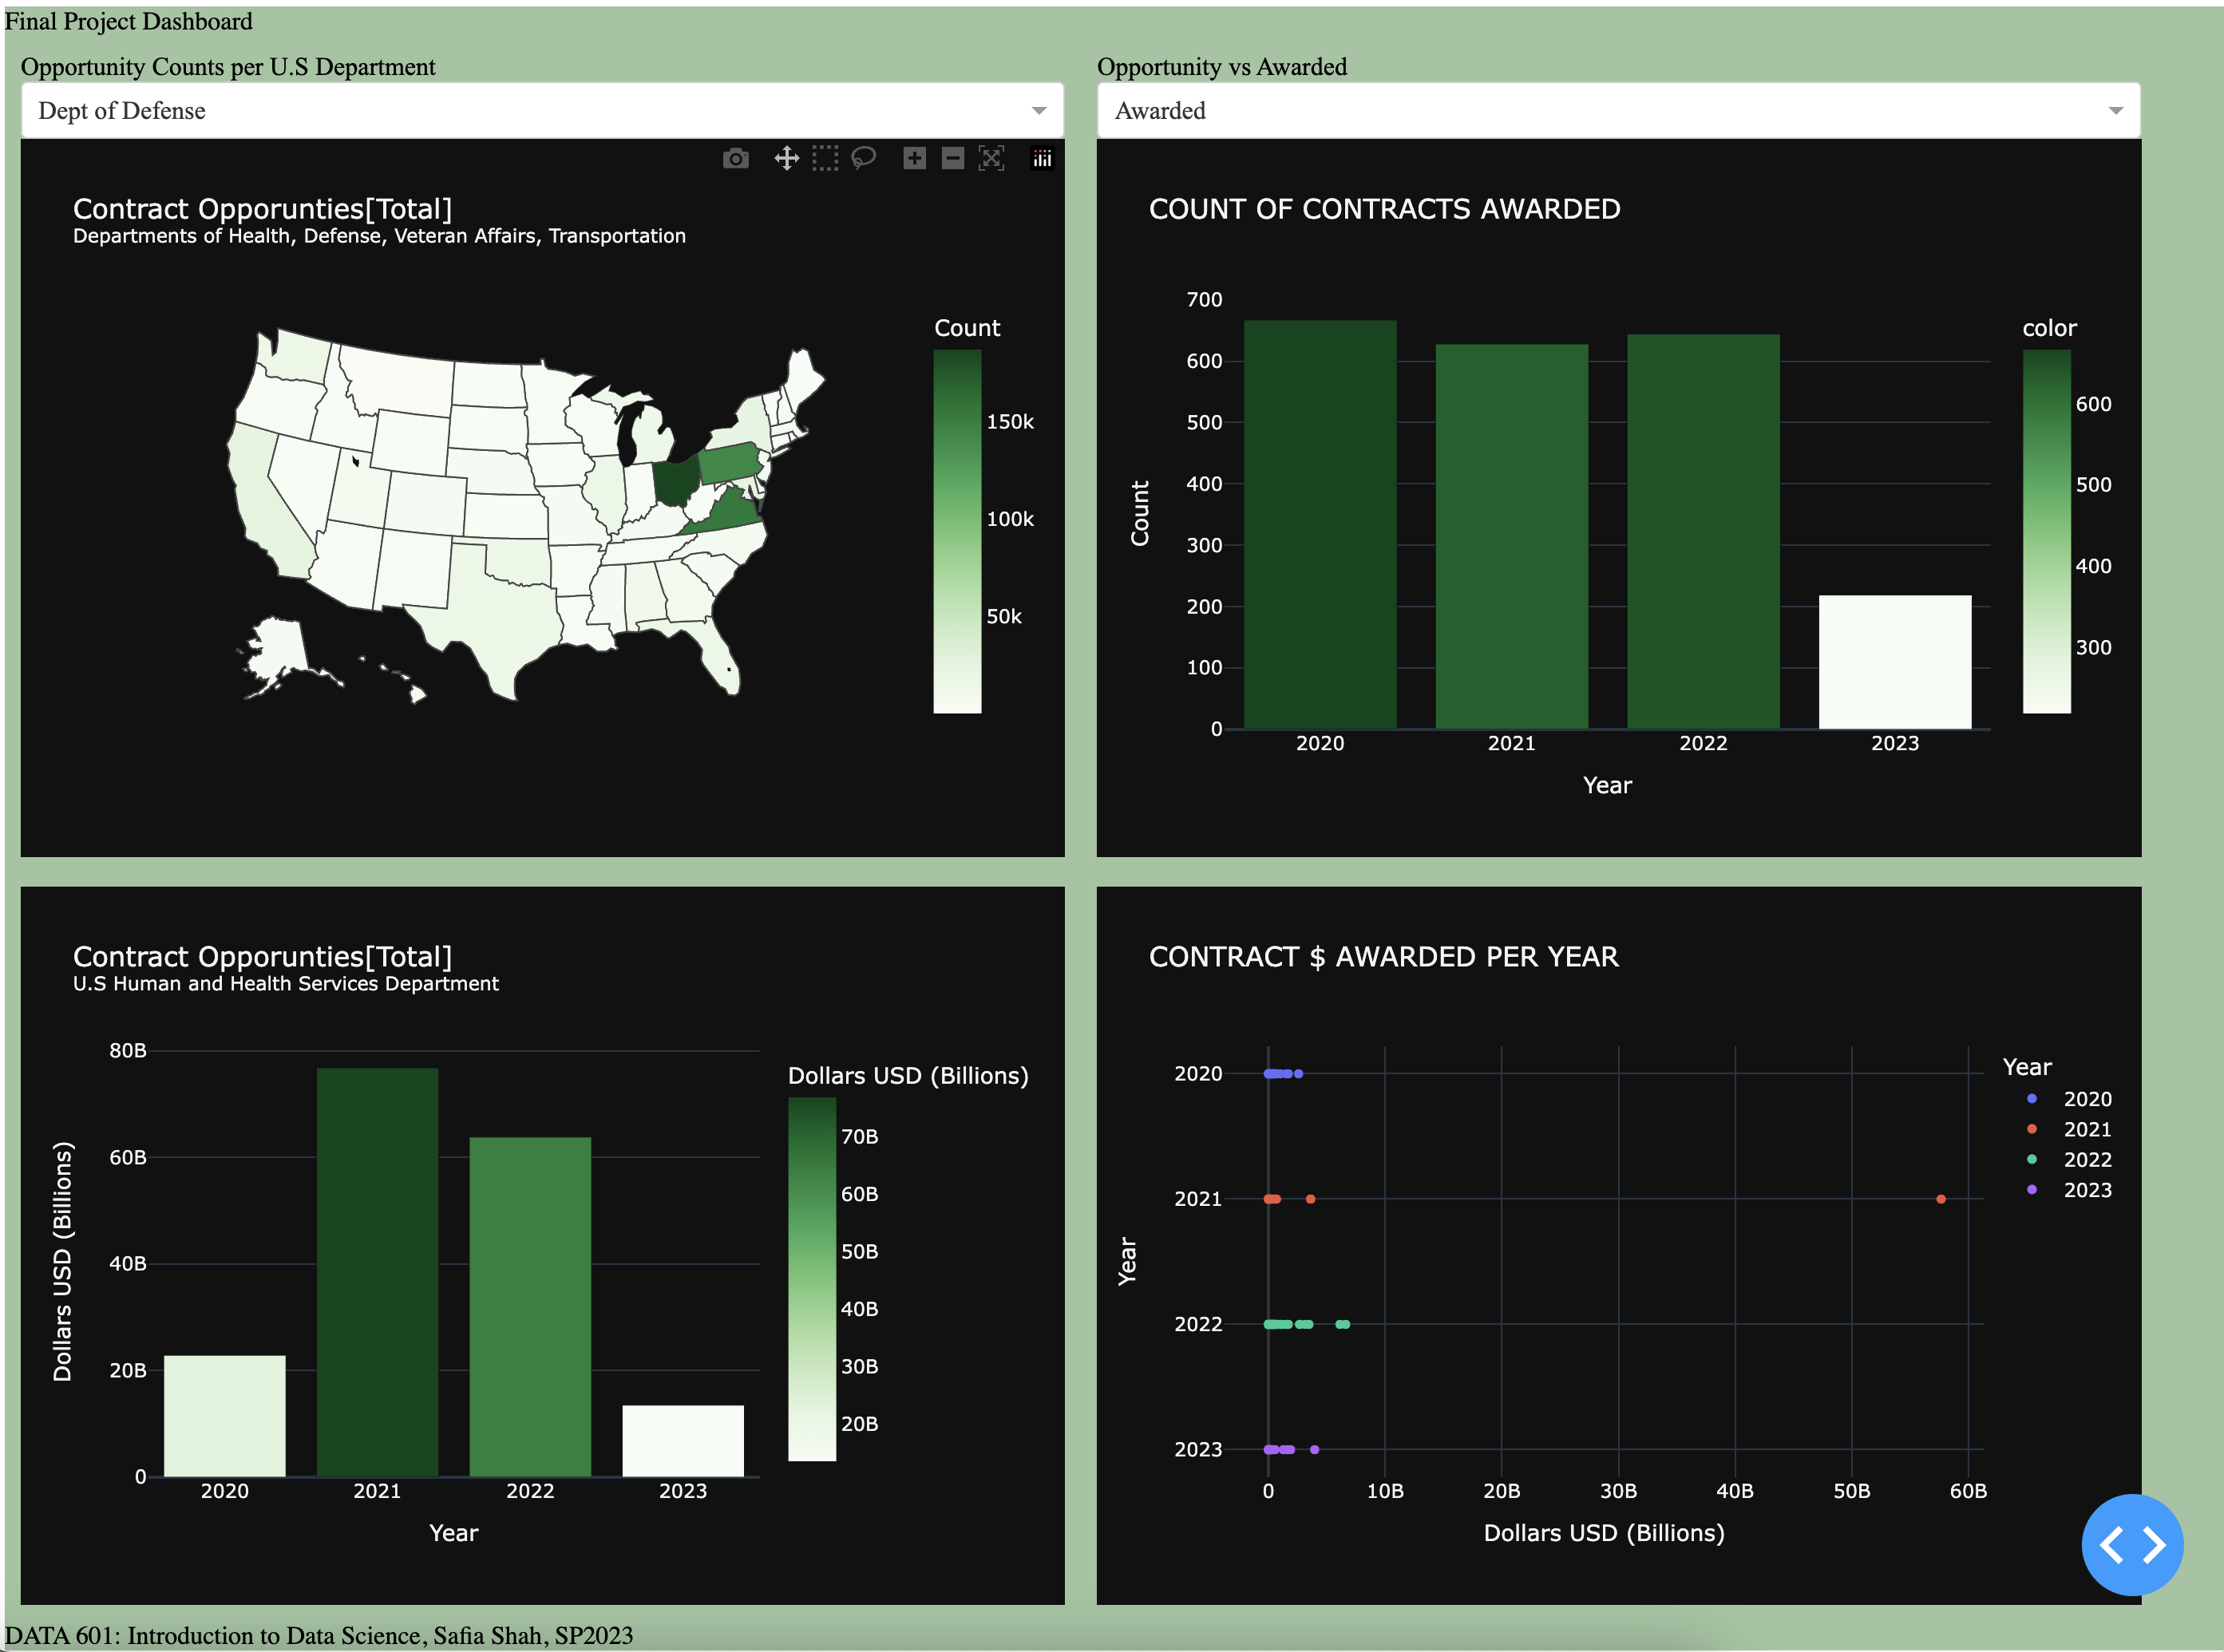

In [8]:
# creating the dash app and components

# Build App
app = JupyterDash(__name__)

# all components are in this layout
app.layout = html.Div([ # full div
    html.Header("Final Project Dashboard"),
    # ----------------------------------------- left column --------------------------------- 
    html.Div(children=[
        # choropleth graph
        html.Label([
        "Opportunity Counts per U.S Department",
        dcc.Dropdown(id='dept-dropdown', 
                    clearable=False, 
                    value='DEPT OF DEFENSE',
                    multi=False,
                    placeholder='Select a Dept',
                    options=[{'label':'Dept of Defense','value':'DEPT OF DEFENSE'},
                             {'label':'Dept of Human and Health Services','value':'HEALTH AND HUMAN SERVICES, DEPARTMENT OF'},
                             {'label':'Dept of Vet affairs','value':'VETERANS AFFAIRS, DEPARTMENT OF'},
                             {'label':'Dept of Transportation','value':'TRANSPORTATION, DEPARTMENT OF'}
                            ]
                    )
    ], style={'fontFamily':'Times New Roman'}), # end of label
        dcc.Graph(id='award-map', figure={}),
        
        # bar plot for sum of contracts awarded or opportunities
        html.Br(),
        dcc.Graph(id='barplot', figure=barplot),

    ], id='visualization', style={'padding': '10px','display':'inline-block', 'width':'47%'}),

# ----------------------------------------- right column --------------------------------- 

    html.Div([
        
        # ---- Opportunity vs Award bar graph label and dropdown (counts)
        html.Label([
        "Opportunity vs Awarded",
        dcc.Dropdown(id='award-opp-dropdown', 
                    clearable=False, 
                    value='awarded',
                    multi=False,
                    placeholder='Select to Visualize Opportunities or Awarded Contracts',
                    options=[{'label':'Awarded','value':'awarded'},
                             {'label':'Opportunities','value':'opportunity'}
                            ]
                    )
    ], style={'fontFamily':'Times New Roman'}), # end of label
        # actual graph call
        dcc.Graph(id='awarded_v_opp', figure={}),
        
        # scatter plot each awarded contract and how much each point is
        html.Br(),
        dcc.Graph(id='scatter-awarded', figure=scatter),

    ], id= 't-test-data',style={'padding': '10px','display':'inline-block','width':'47%'}),


    # ------------------- Footer -----------------------------------------------
    html.Footer("DATA 601: Introduction to Data Science, Safia Shah, SP2023")

], id='full-container', style={'backgroundColor':'#A1C4A1'})

# ------------- connect plotly graph with dash components ------------------

@app.callback(
    Output(component_id='award-map',component_property='figure'),
    Input(component_id='dept-dropdown',component_property='value')

)
# Function: update_dept() -- takes in the user selected value from the department dropdown as seen in the callback input method
# Function takes in selected dropdown value for dept-selected in total contract opportunities map, and gives user 
# a choropleth map showing the count for that department in each state 
def update_dept(selected):
    print(selected, type(selected))

    titles = {'DEPT OF DEFENSE':'Department of Defense',
         'HEALTH AND HUMAN SERVICES, DEPARTMENT OF':'Dept of Human and Health Services',
         'VETERANS AFFAIRS, DEPARTMENT OF':'Department of Vet affairs',
         'TRANSPORTATION, DEPARTMENT OF':'Dept of Transportation'}

    dff = dpt_state_gp.copy()
    dff = dff[dff['Department/Ind.Agency'] == selected]
    
    fig = px.choropleth(data_frame=dff,
                        locationmode='USA-states',
                        locations='State',
                        scope= 'usa',
                        labels={'Count of Awards offered': 'Count of Awards'},
                        color='Count',
                        color_continuous_scale= px.colors.sequential.Greens,
                        template='plotly_dark',
                        hover_data={'State','Count','Department/Ind.Agency'},
                        title='Contract Opporunties[Total]<br><sup>Departments of Health, Defense, Veteran Affairs, Transportation</sup>')
    
    return fig # what you return here is going to the output

# ------- Callback to update bar graph for with Total Opportunities for HHS vs Actual Number of Rewards Recieved

@app.callback(
    Output(component_id='awarded_v_opp',component_property='figure'),
    Input(component_id='award-opp-dropdown',component_property='value')

)

# Function: update_comparison() -- takes in the user selected value from the dropdown which is either 'opportunity'
# or 'awarded' and depending on its input it which show a bar graph of the counts of either values grouped by year
def update_comparison(selected):

    if selected == 'opportunity':
        dff = opportunities_gp.copy()
        fig = px.bar(dff, x=dff.index,y=dff.values,
                    color=dff.values,
                    color_continuous_scale= px.colors.sequential.Blues,
                    title= 'COUNT OF CONTRACT OPPORTUNITIES',
                    labels={'year': 'Year', 'y':'Count'})
    else:
        dff = award_gp.copy()
        fig = px.bar(dff, x=dff.index,y=dff.values,
                    color=dff.values,
                    color_continuous_scale= px.colors.sequential.Greens,
                    title = "COUNT OF CONTRACTS AWARDED",
                    labels={'year': 'Year', 'y':'Count'})
   
    fig.update_layout(template='plotly_dark')
   
    return fig
# run the dash app, opens dashboard in an external tab 
app.run_server()
    

Dash is running on http://127.0.0.1:8050/

Dash app running on http://127.0.0.1:8050/


Hypothesis: There is more contract money awarded to the Department of Human Health Services post 2020 world pandemic than years prior. 

Null Hypothesis: there is no statistically significant increase in money awarded to the Dept of HHS pre and post

Limitations:
- for this example I do a one-sample t-test because years prior to 2020 (as far back as 2015) do not have data of opportunities that roll up from sub-tier departments to the HHS. So I use a one-sample t-test with a mu value of 0. This is not a complete accurate depication but does apply here for the department not the subtiers that may be granted money prior to 2020

Method of Statistical testing:
- data set from 2020-2023
- one sample t-test - upper tail
    - https://www.jmp.com/en_us/statistics-knowledge-portal/t-test/one-sample-t-test.html
    - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_1samp.html : scipy stats library
    
Current skill level limitation: keeping t-test application and result in the jupyter notebook and not on the dashboard

In [9]:
import scipy.stats as stats

In [10]:
# dropping rows with null values for award money in HHS
alpha = 0.05
HHS.dropna(axis=0, subset= ['Award$'], inplace=True)
#HHS.info()
awarded = HHS['Award$'].astype('float')
awarded.dtype
# conducting the upper tail - one sample t-test
t_stat, p_value = stats.ttest_1samp(a=awarded, popmean=0, alternative='greater')
print('T-stat:', t_stat,"\nP-val", p_value)

print("Reject Null Hypothesis") if p_value <= alpha else print("Fail To Reject Null Hypothesus")

T-stat: 2.9845115445950863 
P-val 0.0014361130413813013
Reject Null Hypothesis


As you can see above: 
- using the pop mean of 0 to account for the HHS department as a whole not getting awared years prior to 2020, the P-value is less than the alpha value 0.05 so we can then *reject the null hypothesis* and say that there is a statistically significant increase in the money awarded to the HHS 2020-2023

(Reject the null hypothesis when the p-value is less than or equal to your significance level alpha=0.05)

Now this statistic is not that realistic with the popmean being 0. As mentioned before 'the money are typically not awarded by the secretary’s office but by the sub agency. The number probably won’t really roll up to hhs.' (Prof Wan in an email exchange to explain how money allocation works). 
- Therefore, for the next section I will focus on two major sub-tier players : National Institute of Health (NIH) and Food and Drug Administration (FDA)
- the hypothesis will be the same just for the sum of the two departments above, and the data set will now include 2018-2019 as one observation and the second being 2020-2021
- once the dataset has been cleaned to only include non null 'Award$' values and the column is cleaned to be only the award amount (.strip(), replace and letters to '', and type cast to float), then conduct 2 sample t-test for the upper tail same as above


In [11]:
# Load datasets for 2018 and 2019
filesRemaining = ['FY2018_archived_opportunities.csv','FY2019_archived_opportunities.csv']
start_time = time.time() # Stamp time to get duration of file reading

contracts18_19 = pd.concat(pd.read_csv(filesRemaining[i], encoding='iso-8859-1',low_memory = False, usecols=['NoticeId', 'Title','Department/Ind.Agency','Sub-Tier',
                                                                                        'Office','PostedDate','Type','ArchiveDate','Active',
                                                                                        'Award$','Awardee','State']) 
               for i in range(len(filesRemaining)))

contracts20_21 = pd.concat([contract2020,contract2021])

print("Duration of file reading: ", time.time() - start_time, " seconds")
print(contracts18_19.shape)


Duration of file reading:  5.983098030090332  seconds
(755418, 12)


In [12]:
subtiers = ['FOOD AND DRUG ADMINISTRATION','NATIONAL INSTITUTES OF HEALTH','Administration for Strategic Preparedness and Response', 'CENTERS FOR DISEASE CONTROL AND PREVENTION']

for i in range(len(subtiers)):
    print("Awarded Contracts for ",subtiers[i])
    print(contracts18_19[contracts18_19['Sub-Tier']==subtiers[i]]['Award$'].count())
    
    
for i in range(len(subtiers)):
    print("Awarded Contracts for ",subtiers[i])
    print(contracts18_19[contracts18_19['Sub-Tier']==subtiers[i]]['NoticeId'].count())
#contracts18_19.head(20)

Awarded Contracts for  FOOD AND DRUG ADMINISTRATION
0
Awarded Contracts for  NATIONAL INSTITUTES OF HEALTH
0
Awarded Contracts for  Administration for Strategic Preparedness and Response
0
Awarded Contracts for  CENTERS FOR DISEASE CONTROL AND PREVENTION
0
Awarded Contracts for  FOOD AND DRUG ADMINISTRATION
0
Awarded Contracts for  NATIONAL INSTITUTES OF HEALTH
0
Awarded Contracts for  Administration for Strategic Preparedness and Response
0
Awarded Contracts for  CENTERS FOR DISEASE CONTROL AND PREVENTION
0
DEPT OF DEFENSE <class 'str'>
HEALTH AND HUMAN SERVICES, DEPARTMENT OF <class 'str'>


Just kidding. As you can see above, even the subtiers for HHS do not have contracted award money given or even opportunities (shown by couting noticeids) in years 2018 and 2019. Therefore, the subtier limitations are stricter as there are no opportunities, let alone awarded contracts. In conclusion, the two sample t-test for the two sets of years can not be done. This dataset seems a bit unrealistic ,but I worked with the data I had.